<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/combining_subnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up and Data Loading/Processing

In [1]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"
!pip install unrar
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"

Cloning into 'EC523-Deep-Learning-Project'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 71 (delta 10), reused 6 (delta 1), pack-reused 40
Unpacking objects: 100% (71/71), done.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

transform = transforms.Normalize(mean=129.4456, std = 1)

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [4]:

class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample


# mu, st = 129.4456, 255
mu, st = 0, 255

train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ]) 

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [5]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

   Fear Surprise     Sad    Fear   Happy


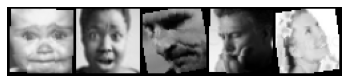

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

# Combining Three Subnets

In [7]:
# All model class definitions
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.lin1 = nn.Linear(256*6*6, 4096) # Will have to change input size
        self.lin2 = nn.Linear(4096, 4096)
        #self.lin3 = nn.Linear(4096, 7)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)


        x = x.view(-1, 256*6*6) # will have to change!
        # print("reshaped", x.shape)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        #x = self.lin3(x)

        return x

class Subnet2(nn.Module):
    def __init__(self):
        super(Subnet2, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        #self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool(x)

        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        #x = self.lin3(x)

        return x


class Subnet3(nn.Module):
    def __init__(self):
        super(Subnet3, self).__init__()
        # Not sure about number of in channels, may have to change!

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        #self.lin3 = nn.Linear(4096, 7)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        x = x.view(-1, 256*6*6) # CHANGE
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        #x = self.lin3(x)

        return x



In [8]:
# Load models
#sub1 = Subnet1()
#sub1.load_state_dict(torch.load(''))
#sub2 = Subnet2()
#sub2.load_state_dict(torch.load(''))
#sub3 = Subnet3()
#sub3.load_state_dict(torch.load(''))

FileNotFoundError: ignored

In [13]:
class CombinedNets(nn.Module):
    def __init__(self):
        super(CombinedNets, self).__init__()
        # Not sure about number of in channels, may have to change!
        # for net 1
        self.sub1 = Subnet1()

        self.sub2 = Subnet2()

        self.sub3 = Subnet3()
        # for net2

        self.final_lin = nn.Linear(4096*3, 7)

    def forward(self, x):
        x_1 = self.sub1(x)
        x_2 = self.sub2(x)
        x_3 = self.sub3(x)

        # concatenate x_1, x_2, x_3
        #third_tensor= tf.concat(0, [first_tensor, second_tensor])

        #print(x_1.shape, x_2.shape, x_3.shape)

        x_cat = torch.cat((x_1, x_2, x_3), dim=1)

        #print(x_cat.shape)
        #input("Type E to continue...")

        x = self.final_lin(x_cat)

        return x

# INSTANTIATE NET
net = CombinedNets()
net = net.to(device)

In [14]:
def train_model(net, trainloader, valloader, n_epochs=20):

    train_loss = []
    val_loss = []
    num = 10
    for epoch in range(n_epochs):
        print("Training")
        net = net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % num == num - 1 :    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                train_loss.append(running_loss / num)
                running_loss = 0.0
        
        print("Validating")
        net = net.eval()
        running_loss = 0.0
        for i, data in enumerate(valloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item()
            if i % num == num - 1:    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                val_loss.append(running_loss / num)
                running_loss = 0.0

    return train_loss, val_loss

In [11]:
def test_model(net, dataloader):
    
    net = net.eval()

    correct_count, n_samples = 0.0, 0.0
    for data in dataloader:
        # seperate data to X, y and more info to GPU
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)
    
    acc = 100 * correct_count / n_samples
    
    return acc

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

train_loss, val_loss = train_model(net, trainloader, valloader, n_epochs=25)

Training
[1,    10] loss: 1.933
[1,    20] loss: 1.888
[1,    30] loss: 1.854
[1,    40] loss: 1.826
[1,    50] loss: 1.822
[1,    60] loss: 1.835
[1,    70] loss: 1.820
[1,    80] loss: 1.825
[1,    90] loss: 1.810
[1,   100] loss: 1.813
[1,   110] loss: 1.788
[1,   120] loss: 1.816
[1,   130] loss: 1.818
[1,   140] loss: 1.813
[1,   150] loss: 1.809
[1,   160] loss: 1.798
[1,   170] loss: 1.810
[1,   180] loss: 1.802
[1,   190] loss: 1.814
[1,   200] loss: 1.818
[1,   210] loss: 1.803
[1,   220] loss: 1.807
[1,   230] loss: 1.837
[1,   240] loss: 1.816
[1,   250] loss: 1.808
[1,   260] loss: 1.800
[1,   270] loss: 1.807
[1,   280] loss: 1.813
Validating
[1,    10] loss: 1.820
[1,    20] loss: 1.805
[1,    30] loss: 1.813
Training
[2,    10] loss: 1.809
[2,    20] loss: 1.806
[2,    30] loss: 1.786
[2,    40] loss: 1.814
[2,    50] loss: 1.794
[2,    60] loss: 1.813
[2,    70] loss: 1.788
[2,    80] loss: 1.807
[2,    90] loss: 1.794
[2,   100] loss: 1.801
[2,   110] loss: 1.802
[2,  

In [16]:
path = 'combined_nets'
torch.save(net.state_dict(), path)
from google.colab import files
files.download(path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

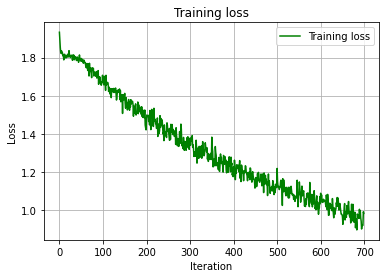

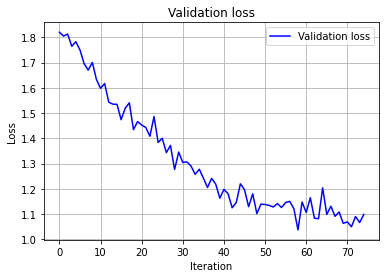

In [17]:
plt.figure()
plt.plot(train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [18]:
acc = []
dataloaders = [trainloader, valloader, testloader]
for loader in dataloaders:
    acc.append(test_model(net, loader))

print('Train Accuracy: %2.2f %%' % (acc[0]))
print('Val Accuracy: %2.2f %%' % (acc[1]))
print('Test Accuracy: %2.2f %%' % (acc[2]))

Train Accuracy: 64.77 %
Val Accuracy: 59.54 %
Test Accuracy: 59.32 %
